# Intro
Post-processing of detections will be key in this competition I think. To do proper filtering if detections we need a clear picture of the statistics of each of the three cell types. The aim of this notebook is to give some guidelines for post processing features regardless of which model is used.  

We will use the segments created in [this notebook](https://www.kaggle.com/mistag/sartorius-create-coco-annotations), which eliminate the most obvious bad annotations from the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from skimage import measure 
import cv2
from tqdm import tqdm
sns.set(rc={'figure.figsize':(12,8)})

A few helper functions:

In [2]:
# create mask from polygon
def get_shape(loc):
    shape = df.iloc[loc]['shape']
    mask = np.zeros((520, 704), dtype=np.uint8)
    cv2.fillPoly(mask, [shape], 1)
    mask = mask.astype(bool)
    x1, y1 = df.iloc[loc]['x_top_left'], df.iloc[loc]['y_top_left']
    x2, y2 = x1+df.iloc[loc]['bbox_width'], y1+df.iloc[loc]['bbox_height']
    return mask[max(0,y1-5):min(520,y2+5),max(0,x1-5):min(704,x2+5)]*1

CELLS = ['shsy5y', 'astro', 'cort']

# get statistics for a given feature
def feature_stat(feature):
    cell_stat = []
    for i in range(3):
        stat = df[df.cell_type == CELLS[i]][feature].describe([.01, .05, .95, .99])
        cell_stat.append([CELLS[i],
                          int(stat['count']),
                          round(stat['min'], 3),
                          round(stat['max'], 3),
                          round(stat['mean'], 3),
                          round(stat['std'], 3),
                          round(stat['1%'], 3),
                          round(stat['5%'], 3),
                          round(stat['95%'], 3),
                          round(stat['99%'], 3)])
    df_stat = pd.DataFrame(cell_stat, columns=['Cell Type', 'Cell Count', 
                                               'Min {}'.format(feature), 
                                               'Max {}'.format(feature), 
                                               'Mean {}'.format(feature), 
                                               '{} std'.format(feature),
                                               '1%', '5%', '95%', '99%'])
    return df_stat

# visualize solidity
def show_solidity(id):
    all_props = measure.regionprops(get_shape(id))
    ctype = df.iloc[id]['cell_type']
    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    fig.tight_layout()
    plt.subplot(1,2,1)
    plt.imshow(get_shape(id))
    ax[0].set_aspect(1)
    ax[0].grid(False)
    plt.title('{}: Original shape (Solidity={})'.format(ctype, round(all_props[0].solidity, 3)))
    plt.subplot(1,2,2)
    ax[1].set_aspect(1)
    ax[1].grid(False)
    plt.title('Convex shape')
    plt.imshow(all_props[0].convex_image);
    
# list format: [feature, shsy5y min, shsy5y max, astro min, astro max, cort min, cort max]
criteria = []

# add criteria for post processing
def add_criteria(dfs, fname):
    criteria.append([fname, 
                     dfs[dfs['Cell Type'] == 'shsy5y']['1%'][0],
                     dfs[dfs['Cell Type'] == 'shsy5y']['99%'][0],
                     dfs[dfs['Cell Type'] == 'astro']['1%'][1],
                     dfs[dfs['Cell Type'] == 'astro']['99%'][1],
                     dfs[dfs['Cell Type'] == 'cort']['1%'][2],
                     dfs[dfs['Cell Type'] == 'cort']['99%'][2]])

# Create DataFrame with cell data
Start by reading in .json files representing the entire train data set. We assume that the train data set is representative of the hidden test data set.

In [3]:
data = []

def add_features(jfile, dlist):
    with open(jfile, 'r') as f:
        jdata = json.load(f)
    for i in range(len(jdata['annotations'])):
        shape = jdata['annotations'][i]['segmentation'][0]
        shape = np.reshape(shape, [len(shape)//2, 2]).astype(np.int32)
        dlist.append([jdata['categories'][jdata['annotations'][i]['category_id']-1]['name'], #cell type
                      #jdata['annotations'][i]['area'], # segment area
                      jdata['annotations'][i]['bbox'][0], # x top-left
                      jdata['annotations'][i]['bbox'][1], # y top left
                      jdata['annotations'][i]['bbox'][2], # width
                      jdata['annotations'][i]['bbox'][3], # height
                      shape, # shape
                      ]) 
    return dlist

In [4]:
data = add_features('../input/sartorius-create-coco-annotations/train_fold_0.json', data)
data = add_features('../input/sartorius-create-coco-annotations/test_fold_0.json', data)
df = pd.DataFrame(data, columns=['cell_type', 'x_top_left', 'y_top_left', 'bbox_width', 'bbox_height', 'shape'])

## Create additional features
Here we use [skimage.measure.regionprops](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) to extract a whole range of features of each cell mask. The analysis below will focus on the following features:  
  * Area 
  * Major and minor axis length of the ellipse that has the same normalized second central moments as the region
  * Minor/major axis ratio
  * Solidity (Ratio of pixels in the region to pixels of the convex hull image)
  * Extent (Ratio of pixels in the region to pixels in the total bounding box)
  * Hu moments
  
There are other features that could be analysed as well.

In [5]:
# additional features
solidity = []
major_axis_length = []
minor_axis_length = []
extent = []
hu_moments = []
area = []
for i in tqdm(range(len(df))):
    mask = get_shape(i)
    all_props = measure.regionprops(mask)
    solidity.append(all_props[0].solidity)
    major_axis_length.append(all_props[0].major_axis_length)
    minor_axis_length.append(all_props[0].minor_axis_length)
    extent.append(all_props[0].extent)
    hu_moments.append(all_props[0].moments_hu)
    area.append(all_props[0].area)

100%|██████████| 73557/73557 [02:44<00:00, 446.99it/s]


In [6]:
df['area'] = area
df['solidity'] = solidity
df['major_axis_len'] = major_axis_length
df['minor_axis_len'] = minor_axis_length
max_ax_len = np.asarray(major_axis_length)
max_ax_len[max_ax_len == 0] = 1
df['axis_ratio'] = np.asarray(minor_axis_length)/max_ax_len
df['extent'] = extent
for i in range(7):
    df['hu_{}'.format(str(i))] = np.asarray(hu_moments)[:,i]

# Area
Let's start by looking at area histogram - clearly the astro cells have a much larger area range the the others.

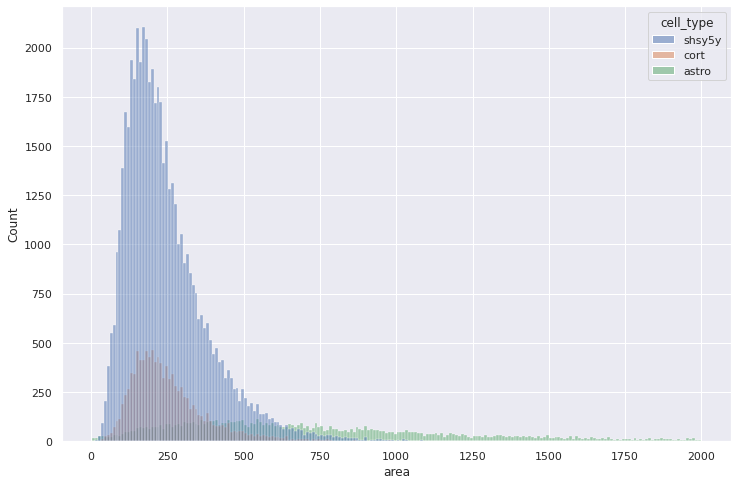

In [7]:
sns.histplot(data=df[df.area < 2000], x="area", hue='cell_type');

We want to avoid including the extreme outliers when filtering predictions, so in the following we find the 1% and 5% upper and lower percentiles for each feature as a baseline for min and max values to check against.

In [8]:
fs = feature_stat('area')
add_criteria(fs, 'area')
fs

,Cell Type,Cell Count,Min area,Max area,Mean area,area std,1%,5%,95%,99%
0,shsy5y,52283,10.0,2364.0,249.720,145.289,57.0,88.0,524.0,752.18
1,astro,10497,4.0,11919.0,896.813,828.037,46.0,153.8,2347.6,4259.92
2,cort,10777,27.0,2168.0,261.831,146.765,70.0,107.0,533.0,776.24


# Major and minor axis
The major and minor axis (and ratio) of a segment is defined as (image credit: Nattapon Mahavik):   
![ilu](https://www.researchgate.net/profile/Nattapon-Mahavik/publication/344473808/figure/fig1/AS:943223530864640@1601893422337/Schematic-of-the-fitting-ellipse-shown-in-the-biggest-ellipse-envelopes-of-the-convective.jpg)  

Circular shapes will have axis ratio close to 1 while very long and thin shapes will have axis ratio close to 0. Let's take a look at major axis length:

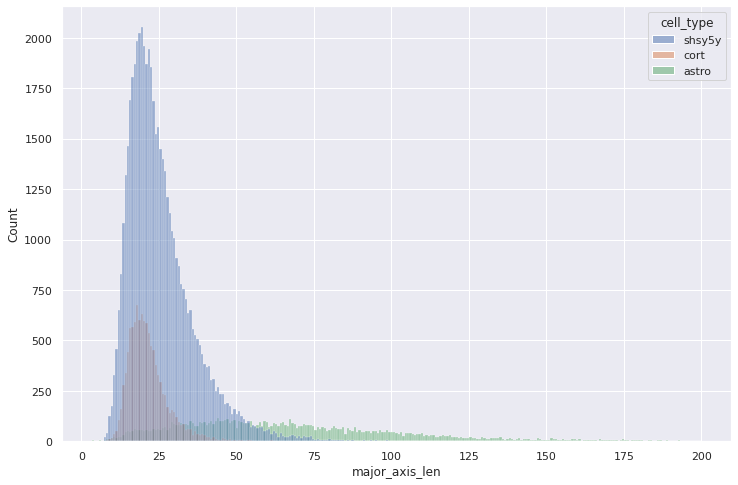

In [9]:
sns.histplot(data=df[df['major_axis_len'] < 200], x="major_axis_len", hue='cell_type');

And the statistics:

In [10]:
fs = feature_stat('major_axis_len')
add_criteria(fs, 'major_axis_len')
fs

,Cell Type,Cell Count,Min major_axis_len,Max major_axis_len,Mean major_axis_len,major_axis_len std,1%,5%,95%,99%
0,shsy5y,52283,6.103,117.086,25.734,11.035,10.597,13.146,46.878,63.822
1,astro,10497,3.464,485.653,68.860,40.548,12.204,19.085,143.674,205.016
2,cort,10777,7.585,140.802,21.565,6.913,11.533,13.590,34.037,45.296


Then the minor axis:

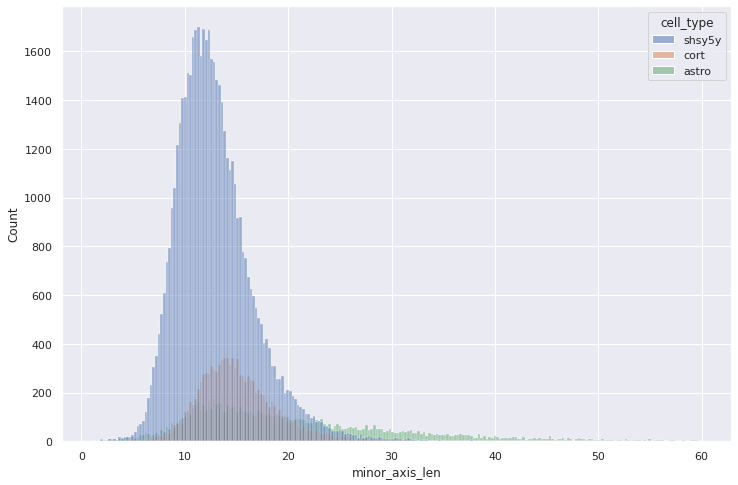

In [11]:
sns.histplot(data=df[df['minor_axis_len'] < 60], x="minor_axis_len", hue='cell_type');

Less of a difference here, as expected.

In [12]:
fs = feature_stat('minor_axis_len')
add_criteria(fs, 'minor_axis_len')
fs

,Cell Type,Cell Count,Min minor_axis_len,Max minor_axis_len,Mean minor_axis_len,minor_axis_len std,1%,5%,95%,99%
0,shsy5y,52283,1.365,46.204,12.932,3.838,6.362,7.906,19.961,25.255
1,astro,10497,1.029,183.879,21.443,12.800,4.487,8.306,45.445,67.978
2,cort,10777,2.795,46.304,15.181,4.049,7.264,9.668,22.606,27.526


Finally we look at the minor/major axis ratio:

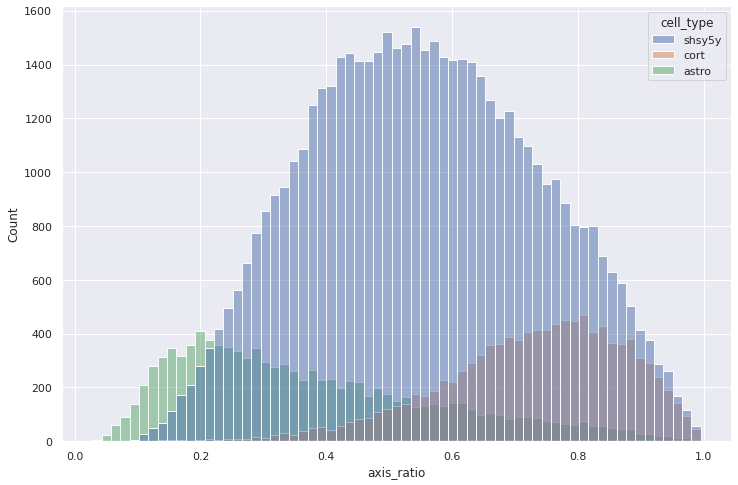

In [13]:
sns.histplot(data=df[df['axis_ratio'] < 10], x="axis_ratio", hue='cell_type');

In [14]:
fs = feature_stat('axis_ratio')
add_criteria(fs, 'axis_ratio')
fs

,Cell Type,Cell Count,Min axis_ratio,Max axis_ratio,Mean axis_ratio,axis_ratio std,1%,5%,95%,99%
0,shsy5y,52283,0.048,0.994,0.555,0.184,0.184,0.263,0.865,0.940
1,astro,10497,0.028,0.995,0.374,0.206,0.076,0.117,0.782,0.903
2,cort,10777,0.114,0.993,0.727,0.146,0.326,0.458,0.932,0.970


# Solidity
The solidity represents the ratio of pixels in the region to pixels of the convex hull image. So a convex cell will have solidity=1. Let's take a look at a few cells:

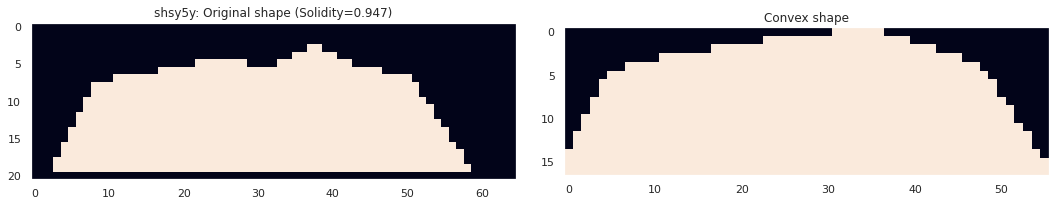

In [15]:
show_solidity(69565)

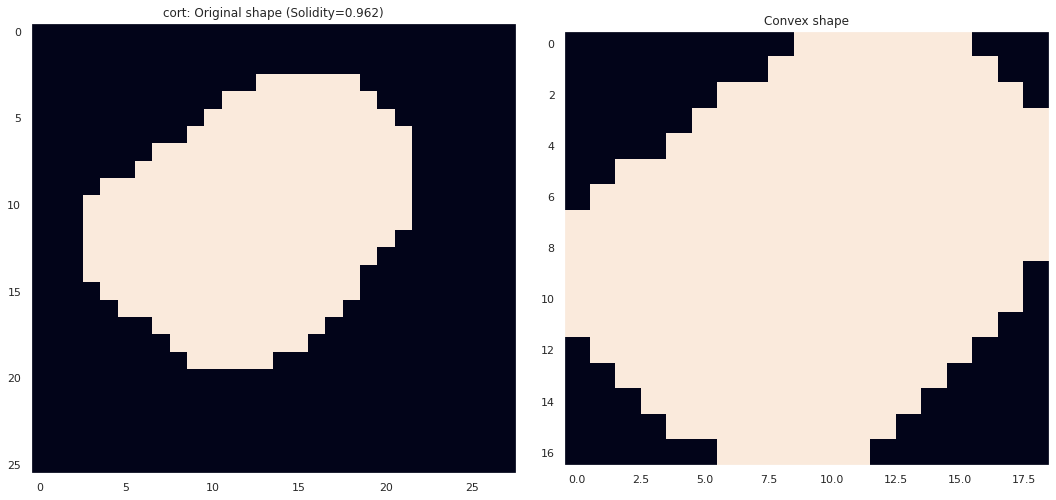

In [16]:
show_solidity(48407)

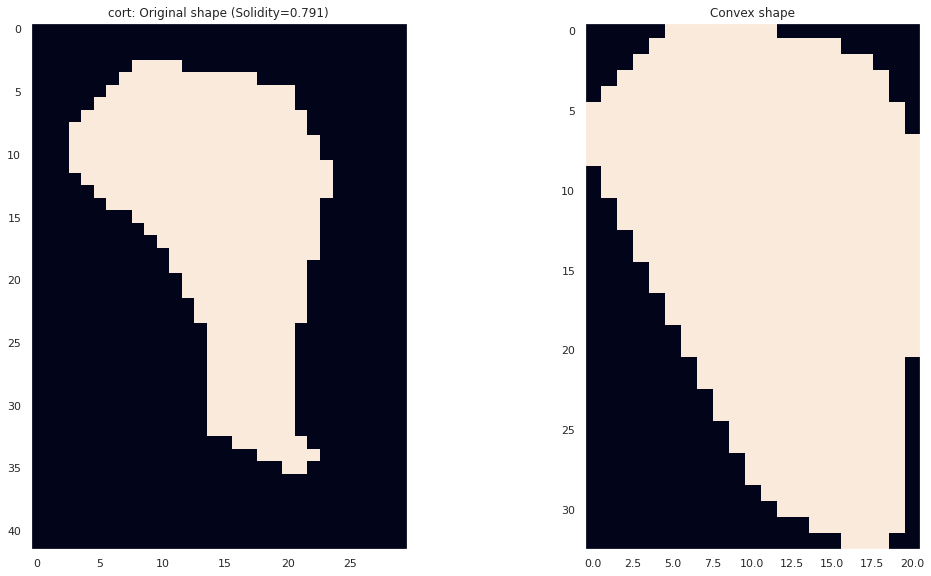

In [17]:
show_solidity(41909)

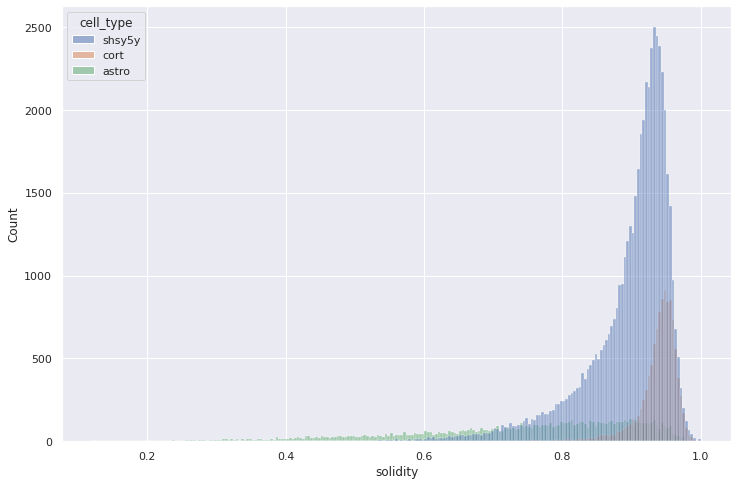

In [18]:
sns.histplot(data=df, x="solidity", hue='cell_type');

In [19]:
fs = feature_stat('solidity')
add_criteria(fs, 'solidity')
fs

,Cell Type,Cell Count,Min solidity,Max solidity,Mean solidity,solidity std,1%,5%,95%,99%
0,shsy5y,52283,0.340,1.0,0.896,0.065,0.656,0.761,0.959,0.972
1,astro,10497,0.121,1.0,0.743,0.162,0.292,0.426,0.944,0.964
2,cort,10777,0.428,1.0,0.937,0.033,0.806,0.877,0.970,0.979


# Extent
Extent represents the ratio of pixels in the region to pixels in the total bounding box. 

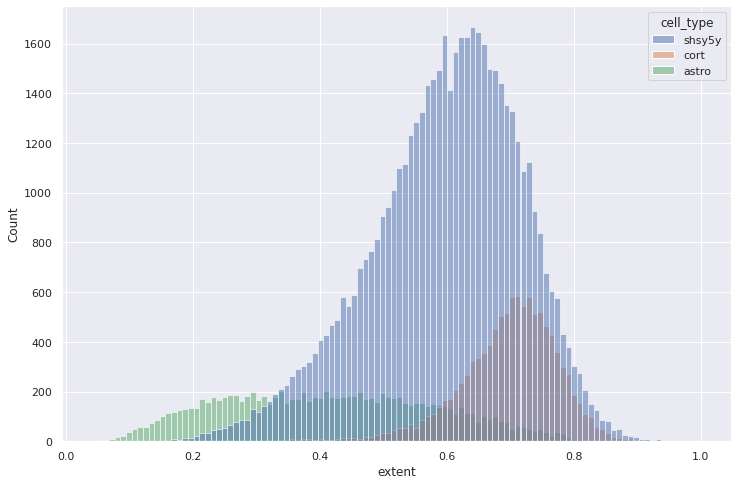

In [20]:
sns.histplot(data=df, x="extent", hue='cell_type');

In [21]:
fs = feature_stat('extent')
add_criteria(fs, 'extent')
fs

,Cell Type,Cell Count,Min extent,Max extent,Mean extent,extent std,1%,5%,95%,99%
0,shsy5y,52283,0.088,1.000,0.597,0.119,0.282,0.378,0.772,0.829
1,astro,10497,0.041,0.984,0.415,0.168,0.104,0.156,0.696,0.775
2,cort,10777,0.147,0.945,0.697,0.078,0.456,0.558,0.806,0.847


# Hu moments
There are 7 Hu moments. Hu Moments can be used to describe, characterize, and quantify the shape of a region. Let's start with the lowest order and go up:

In [22]:
feature_stat('hu_0')

,Cell Type,Cell Count,Min hu_0,Max hu_0,Mean hu_0,hu_0 std,1%,5%,95%,99%
0,shsy5y,52283,0.159,1.695,0.226,0.076,0.162,0.166,0.371,0.534
1,astro,10497,0.160,4.923,0.462,0.337,0.164,0.177,1.106,1.719
2,cort,10777,0.160,0.813,0.179,0.031,0.160,0.161,0.226,0.303


In [23]:
feature_stat('hu_1')

,Cell Type,Cell Count,Min hu_1,Max hu_1,Mean hu_1,hu_1 std,1%,5%,95%,99%
0,shsy5y,52283,0.0,2.847,0.027,0.054,0.0,0.001,0.103,0.244
1,astro,10497,0.0,21.599,0.270,0.686,0.0,0.002,1.091,2.864
2,cort,10777,0.0,0.627,0.006,0.018,0.0,0.000,0.022,0.059


In [24]:
feature_stat('hu_2')

,Cell Type,Cell Count,Min hu_2,Max hu_2,Mean hu_2,hu_2 std,1%,5%,95%,99%
0,shsy5y,52283,0.0,2.036,0.002,0.011,0.0,0.0,0.008,0.024
1,astro,10497,0.0,18.776,0.064,0.361,0.0,0.0,0.245,1.077
2,cort,10777,0.0,0.055,0.001,0.002,0.0,0.0,0.002,0.006


Already at the second moment the information is very low, so we will stick to the lowest two orders.

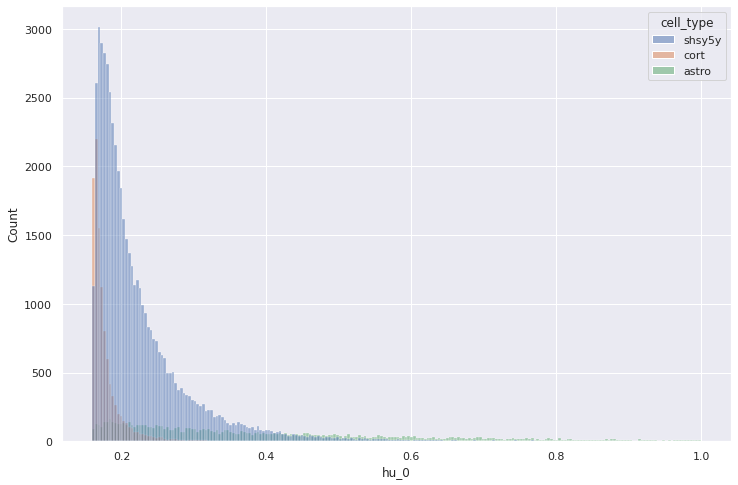

In [25]:
sns.histplot(data=df[df.hu_0 < 1], x="hu_0", hue='cell_type');

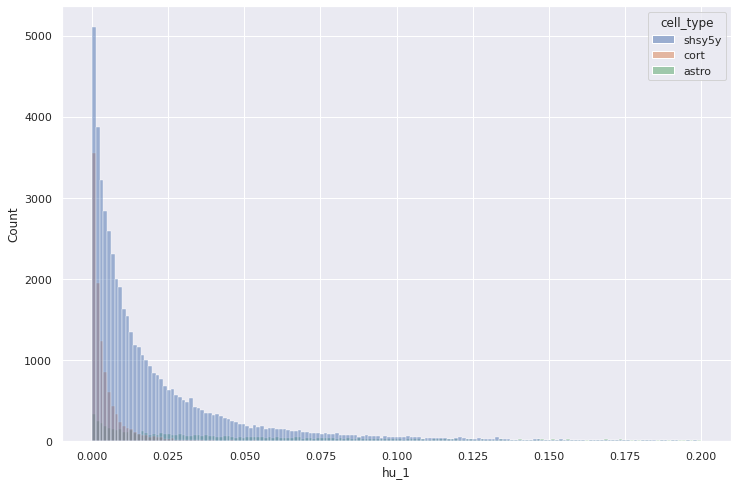

In [26]:
sns.histplot(data=df[df.hu_1 < 0.2], x="hu_1", hue='cell_type');

In [27]:
fs = feature_stat('hu_0')
add_criteria(fs, 'hu_0')
fs = feature_stat('hu_1')
add_criteria(fs, 'hu_1')

# Summary
So, we have collected a few shape features that can be used to filter predictions in post processing. Here is the criteria table (1% and 99% percentiles as min and max respectively):

In [28]:
cdf = pd.DataFrame(criteria,
                  columns = ['feature', 'shsy5y min', 'shsy5y max', 'astro min', 'astro max', 'cort min', 'cort max'])
cdf

,feature,shsy5y min,shsy5y max,astro min,astro max,cort min,cort max
0,area,57.000,752.180,46.000,4259.920,70.000,776.240
1,major_axis_len,10.597,63.822,12.204,205.016,11.533,45.296
2,minor_axis_len,6.362,25.255,4.487,67.978,7.264,27.526
3,axis_ratio,0.184,0.940,0.076,0.903,0.326,0.970
4,solidity,0.656,0.972,0.292,0.964,0.806,0.979
5,extent,0.282,0.829,0.104,0.775,0.456,0.847
6,hu_0,0.162,0.534,0.164,1.719,0.160,0.303
7,hu_1,0.000,0.244,0.000,2.864,0.000,0.059


Oh, and one more thing: It is apparent from the table above that the feature "major axis length" has a minimum value that varies from 10.6 to 12.2 pixels only. This means that we can filter masks based on major axis length with the same threshold (say 10 or 11) for all classes. So if the class prediction is wrong - no effect on our filtering! Area values varies a lot more for comparison.  

Let's save these values to pickle file, for later use.

In [29]:
cdf.to_pickle('shape_data.pkl')